# 뉴스 카테고리 다중분류

|평가문항|상세기준|
|---|---|
|1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

# 패키지 및 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer#DTM패키지
from sklearn.feature_extraction.text import TfidfTransformer#TF-IDF패키지

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 목표

# 1. 모든 단어 사용

# 2. 빈도수 상위 5,000개의 단어만 사용

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## 2.1 데이터 확인

In [3]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


## 2.2 클래스 확인

In [4]:
print(y_train)                          # ndarray type
print(len(y_train))                     # 개수
print(min(y_train),'~', max(y_train))   # class 개수

[ 3  4  3 ... 25  3 25]
8982
0 ~ 45


In [5]:
num_classes = max(y_train) + 1
print(num_classes)

46


## 2.3 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


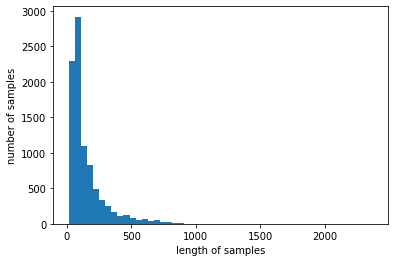

In [6]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 2.3.1 클래스 분포 확인

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

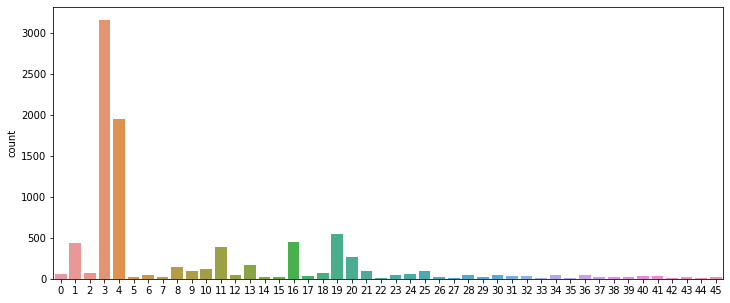

In [7]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

# 3. 직접 단어 개수를 설정해서 사용
* 위 단계에서 5000으로 제시된 nun_words를 다양하게 바꾸어서 확인
* NB, CNB, Logistic Regression, SVM, Decision Tree, RandomForest, Gradient Boost, Voting 사용

## 3.1 num_words 설정 확인

In [8]:
(x_train3, y_train3), (x_test3, y_test3) = reuters.load_data(num_words=3000, test_split=0.2)
(x_train5, y_train5), (x_test5, y_test5) = reuters.load_data(num_words=5000, test_split=0.2)
(x_train10, y_train10), (x_test10, y_test10) = reuters.load_data(num_words=10000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## 3.2 number -> text

In [9]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print(word_index['four'])

185


dictionary 형태로 값이 저장되어 있다.

In [10]:
index_to_word = {index+3 : word for word, index in word_index.items()}

### 3.2.1 OOV 문제 및  UNK token

In [11]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [12]:
def number_to_text(dataset):
    decoded = []
    for i in range(len(dataset)):
        t = ' '.join([index_to_word[index] for index in dataset[i]])
        decoded.append(t)
    return decoded

In [13]:
x_train03 = number_to_text(x_train3)
x_test03 = number_to_text(x_test3)

x_train05 = number_to_text(x_train5)
x_test05 = number_to_text(x_test5)

x_train010 = number_to_text(x_train10)
x_test010 = number_to_text(x_test10)

In [14]:
x_train03[0]

'<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## 3.3 벡터화

### 3.3.1 DTM (Document-Term Matrix)
* BoW들을 결합한 표현 방법
* sklearn CountVectorizer() 사용
* 단점
 * 희소표현(Sparse representation)
 * 단순 빈도 수 기반 접근


* [딥러닝을 이용한 자연어 처리 입문 : DTM](https://wikidocs.net/24559)

In [15]:
def make_dtm(x_train, x_test):
    dtmvector = CountVectorizer()
    dtm = dtmvector.fit_transform(x_train)
    dtm_test = dtmvector.transform(x_test)
    return dtm, dtm_test

In [16]:
x_train_dtm3, x_test_dtm3 = make_dtm(x_train03, x_test03)
x_train_dtm5, x_test_dtm5 = make_dtm(x_train05, x_test05)
x_train_dtm10, x_test_dtm10 = make_dtm(x_train010, x_test010)

print(x_train_dtm3.shape)
print(x_train_dtm5.shape)
print(x_train_dtm10.shape)
print('-'*30)
print(x_test_dtm3.shape)
print(x_test_dtm5.shape)
print(x_test_dtm10.shape)

(8982, 2919)
(8982, 4867)
(8982, 9670)
------------------------------
(2246, 2919)
(2246, 4867)
(2246, 9670)


### 3.3.2 TF_IDF (Term Frequency-Inverse Document Frequency)

* DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법, 사용 방법은 우선 DTM을 만든 후, TF-IDF 가중치를 부여합니다.
* TF-IDF는 TF와 IDF를 곱한 값
* TF는 각 문서에서의 특정 단어 의 등장 횟수.
* DF는 특정 단어가 등장한 문서의 수.
* IDF는 DF의 반비래수 $idf(d, t) = log(\frac{n}{1+df(t)})$
(문서의 수 n이 커질 수록, IDF의 값은 기하급수적으로 커지기 때문에 log 사용 )

In [17]:
def make_tfidf(x_train_dtm, x_test_dtm):
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)
    return tfidfv, tfidfv_test

In [18]:
x_train_tfidfv3, x_test_tfidfv3 = make_tfidf(x_train_dtm3, x_test_dtm3)
x_train_tfidfv5, x_test_tfidfv5 = make_tfidf(x_train_dtm5, x_test_dtm5)
x_train_tfidfv10, x_test_tfidfv10 = make_tfidf(x_train_dtm10, x_test_dtm10)

print(x_train_tfidfv3.shape)
print(x_train_tfidfv5.shape)
print(x_train_tfidfv10.shape)
print('-'*30)
print(x_test_tfidfv3.shape)
print(x_test_tfidfv5.shape)
print(x_test_tfidfv10.shape)

(8982, 2919)
(8982, 4867)
(8982, 9670)
------------------------------
(2246, 2919)
(2246, 4867)
(2246, 9670)


## 3.4 ML Model 적용

In [19]:
def fitting_model(tfidfv, y_train, tfidfv_test, y_test):
    mod = MultinomialNB()
    mod.fit(tfidfv, y_train)
    print(classification_report(y_test, mod.predict(tfidfv_test)))
    
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    print(classification_report(y_test, cb.predict(tfidfv_test)))
    
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    print(classification_report(y_test, lsvc.predict(tfidfv_test)))
    
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)
    print(classification_report(y_test, lr.predict(tfidfv_test)))
    
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    print(classification_report(y_test, tree.predict(tfidfv_test)))
    
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    print(classification_report(y_test, forest.predict(tfidfv_test)))
    
    grbt = GradientBoostingClassifier(random_state=0)
    grbt.fit(tfidfv, y_train)
    print(classification_report(y_test, grbt.predict(tfidfv_test)))
    
    voting = VotingClassifier(estimators=[
        ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))], voting='soft', n_jobs=-1)
    voting.fit(tfidfv, y_train)
    print(classification_report(y_test, voting.predict(tfidfv_test)))

In [20]:
numword_3000_model = fitting_model(x_train_tfidfv3, 
                                   y_train3, 
                                   x_test_tfidfv3, 
                                   y_test3)
print(numword_3000_model)

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.49      0.82      0.61       105
           2       0.00      0.00      0.00        20
           3       0.88      0.88      0.88       813
           4       0.64      0.95      0.76       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.48      0.65        25
          10       1.00      0.10      0.18        30
          11       0.45      0.76      0.56        83
          12       0.00      0.00      0.00        13
          13       0.70      0.19      0.30        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.56      0.76      0.64        99
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.71      0.68      0.69       105
           2       0.75      0.75      0.75        20
           3       0.87      0.89      0.88       813
           4       0.79      0.81      0.80       474
           5       0.00      0.00      0.00         5
           6       0.82      1.00      0.90        14
           7       1.00      0.33      0.50         3
           8       0.58      0.66      0.62        38
           9       0.74      0.80      0.77        25
          10       0.76      0.83      0.79        30
          11       0.59      0.69      0.63        83
          12       0.33      0.23      0.27        13
          13       0.56      0.54      0.55        37
          14       0.50      0.50      0.50         2
          15       0.71      0.56      0.63         9
          16       0.65      0.72      0.68        99
          17       0.83    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.75      0.76       105
           2       0.68      0.85      0.76        20
           3       0.91      0.92      0.91       813
           4       0.78      0.85      0.82       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.65      0.74      0.69        38
           9       0.81      0.84      0.82        25
          10       0.89      0.83      0.86        30
          11       0.60      0.69      0.64        83
          12       0.57      0.31      0.40        13
          13       0.59      0.65      0.62        37
          14       0.50      0.50      0.50         2
          15       0.83      0.56      0.67         9
          16       0.67      0.72      0.69        99
          17       0.82    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.39      0.51       105
           2       0.75      0.45      0.56        20
           3       0.94      0.84      0.89       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.59      0.52      0.55        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.84      0.70        99
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.30      0.58      0.40        12
           1       0.44      0.72      0.55       105
           2       0.12      0.10      0.11        20
           3       0.85      0.91      0.88       813
           4       0.66      0.83      0.73       474
           5       0.00      0.00      0.00         5
           6       0.67      0.57      0.62        14
           7       0.33      0.33      0.33         3
           8       0.54      0.53      0.53        38
           9       0.69      0.44      0.54        25
          10       0.72      0.43      0.54        30
          11       0.54      0.59      0.56        83
          12       0.50      0.15      0.24        13
          13       0.41      0.32      0.36        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.52      0.56        99
          17       0.00    

In [21]:
numword_5000_model = fitting_model(x_train_tfidfv5, 
                                   y_train5, 
                                   x_test_tfidfv5, 
                                   y_test5)
print(numword_5000_model)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.69      0.74      0.72       105
           2       0.78      0.70      0.74        20
           3       0.89      0.90      0.90       813
           4       0.81      0.83      0.82       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.61      0.66      0.63        38
           9       0.79      0.88      0.83        25
          10       0.85      0.77      0.81        30
          11       0.63      0.72      0.67        83
          12       0.38      0.38      0.38        13
          13       0.50      0.51      0.51        37
          14       0.50      0.50      0.50         2
          15       0.80      0.44      0.57         9
          16       0.62      0.69      0.65        99
          17       0.50    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.80      0.79       105
           2       0.74      0.85      0.79        20
           3       0.91      0.93      0.92       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.64      0.74      0.68        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.50      0.50      0.50         2
          15       0.83      0.56      0.67         9
          16       0.67      0.73      0.70        99
          17       0.82    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.40      0.52       105
           2       0.60      0.45      0.51        20
           3       0.94      0.84      0.89       813
           4       0.39      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       1.00      0.57      0.73        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.62      0.48      0.54        83
          12       0.17      0.08      0.11        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.82      0.69        99
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.70      0.67      0.68        99
          17       0.00    

In [22]:
numword_10000_model = fitting_model(x_train_tfidfv10, 
                                    y_train10, 
                                    x_test_tfidfv10, 
                                    y_test10)
print(numword_10000_model)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.71      0.73      0.72       105
           2       0.67      0.80      0.73        20
           3       0.90      0.92      0.91       813
           4       0.81      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       0.72      0.93      0.81        14
           7       1.00      0.67      0.80         3
           8       0.64      0.66      0.65        38
           9       0.80      0.80      0.80        25
          10       0.89      0.83      0.86        30
          11       0.61      0.72      0.66        83
          12       0.33      0.31      0.32        13
          13       0.53      0.49      0.51        37
          14       0.20      0.50      0.29         2
          15       0.50      0.22      0.31         9
          16       0.65      0.72      0.68        99
          17       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.78      0.76       105
           2       0.74      0.85      0.79        20
           3       0.92      0.93      0.93       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.59      0.59      0.59        37
          14       0.50      0.50      0.50         2
          15       0.67      0.44      0.53         9
          16       0.68      0.75      0.71        99
          17       0.75    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.42      0.53       105
           2       0.62      0.50      0.56        20
           3       0.93      0.83      0.88       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.85      0.77      0.81        30
          11       0.64      0.51      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.84      0.69        99
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.22      0.33      0.27        12
           1       0.45      0.77      0.57       105
           2       0.30      0.30      0.30        20
           3       0.82      0.90      0.86       813
           4       0.61      0.83      0.70       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.67      0.53      0.59        38
           9       0.70      0.28      0.40        25
          10       0.75      0.30      0.43        30
          11       0.55      0.59      0.57        83
          12       0.40      0.15      0.22        13
          13       0.37      0.19      0.25        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.59      0.59        99
          17       0.00    

# 4. 딥러닝 모델과 비교해 보기
* 간단한 딥러닝 모델 돌려서 확인
* 별도의 Word2Vec등의 Pretrained model은 사용하지 않도록 할 것

## 4.1 기존 데이터 재활용 및 LSTM 모델 사용

### 4.1.1 데이터 array 변환

In [23]:
X_train = x_train_tfidfv5.todense()
X_test = x_test_tfidfv5.todense()

print(X_train.shape, X_test.shape)
print(type(X_train), type(X_test.shape))

(8982, 4867) (2246, 4867)
<class 'numpy.matrix'> <class 'tuple'>


### 4.1.2 데이터 one hot encoding 변환

In [24]:
y_train = to_categorical(y_train5)
y_test = to_categorical(y_test5)

print(y_train.shape, y_test.shape)
print(type(y_train), type(y_test.shape))

(8982, 46) (2246, 46)
<class 'numpy.ndarray'> <class 'tuple'>


### 4.1.3 LSTM 정의 및 활용

In [25]:
vocab_size= 5000
word_vector_dim =100

# LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(keras.layers.LSTM(128))  
model.add(keras.layers.Dense(46, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 623,182
Trainable params: 623,182
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# Model Checkpoint
mc = ModelCheckpoint('best_tf_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [28]:
# Model fit
history = model.fit(X_train, y_train, batch_size=128, epochs=15, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/15
71/71 [==============================] - 68s 921ms/step - loss: 2.9502 - acc: 0.2944 - val_loss: 2.4221 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_tf_model_LSTM.h5
Epoch 2/15
71/71 [==============================] - 65s 911ms/step - loss: 2.4047 - acc: 0.3499 - val_loss: 2.4161 - val_acc: 0.3620

Epoch 00002: val_acc did not improve from 0.36198
Epoch 3/15
71/71 [==============================] - 65s 911ms/step - loss: 2.4042 - acc: 0.3502 - val_loss: 2.4211 - val_acc: 0.3620

Epoch 00003: val_acc did not improve from 0.36198
Epoch 4/15
71/71 [==============================] - 65s 912ms/step - loss: 2.3934 - acc: 0.3531 - val_loss: 2.4246 - val_acc: 0.3620

Epoch 00004: val_acc did not improve from 0.36198
Epoch 5/15
71/71 [==============================] - 65s 912ms/step - loss: 2.3821 - acc: 0.3510 - val_loss: 2.4216 - val_acc: 0.3620

Epoch 00005: val_acc did not improve from 0.36198
Epoch 6/15
71/71 [======================

In [29]:
loaded_model = load_model('best_tf_model_LSTM.h5')
print('LSTM eval: ', loaded_model.evaluate(X_test, y_test)[1])

71/71 [==============================] - 14s 194ms/step - loss: 2.4221 - acc: 0.3620
LSTM eval:  0.36197686195373535


# 5. 설명

* num_wards를 None으로 하기에는 시간이 너무 오래 걸렸다.
* 앞서 알게된 Stacking ensemble이나 모델의 Hyperparameter 값을 조정한다면 ML의 성능을 조금 더 끌어 올릴 수 있을 것 같다.
* 단순한 1 LSTM Layer로는 성능을 가늠하기 어렵다.   
* num_words 3000과 5000을 비교해보면 성능이 별다른 차이가 없었다.
 * 3000 : 모델 중 Voting 최대 성능 81%
 * 5000 : 모델 중 Voting 최대 성능 82%
 * 10000 : 36%
* Grid Search 및 Random한 방법으로 HyperParameter를 설정하고 catboost 및 stacking ensemble 모델을 사용한 뒤 성능이 좋은 모델끼리 Voting한다면 좋은 결과를 기대할 수 있을 것 같다.

* 동일한 전처리로 수행한 결과 36%로 성능이 좋지 못했다.(TF-IDF 변경 후)
* TF-IDF를 변경하지 않고 해야한다.
 * 시간이 없는 관계로 수행하지 못했다.

# 6. 참고

* [딥러닝을 이용한 자연어 처리 입문 : 로이터 뉴스 데이터](https://wikidocs.net/22933)
* [딥러닝을 이용한 자연어 처리 입문 : 단어의 다양한 표현](https://wikidocs.net/31767)
* [SciPy 압축 희소 행(CSR) 행렬을 NumPy 행렬로 변환하기 : todense](https://rfriend.tistory.com/551)
* [Tensorflow keras : to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)